In [1]:
!pip3 install tensorflow-gpu==2.0.0-beta0

     |████████████████████████████████| 348.9MB 46kB/s 
     |████████████████████████████████| 3.1MB 27.4MB/s 
     |████████████████████████████████| 501kB 46.3MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf
import os
import glob
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow.keras as k
import tensorflow.keras.layers as l
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import random
from keras import optimizers
import pandas as pd

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
# reading above csv files as numpy arrays and check dimmensions

my_train_d = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/train_x.csv',skiprows=1,usecols=range(1,7),sep=',',header=None)
my_train_l = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/train_y.csv',skiprows=1,usecols=range(1,13),sep=',',header=None)
my_val_d = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/val_x.csv',skiprows=1,usecols=range(1,7),sep=',',header=None)
my_val_l = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/val_y.csv',skiprows=1,usecols=range(1,13),sep=',',header=None)
my_test_d = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/test_x.csv',skiprows=1,usecols=range(1,7),sep=',',header=None)
my_test_l = pd.read_csv('/content/drive/My Drive/HAPT Data Set/csv/test_y.csv',skiprows=1,usecols=range(1,13),sep=',',header=None)


print(np.array(my_train_d).shape) 
print(np.array(my_train_l).shape)  # (469194, 12)
print(np.array(my_val_d).shape) 
print(np.array(my_val_l).shape)    # (133831, 12)
print(np.array(my_test_d).shape)   # (69910, 6)
print(np.array(my_test_l).shape)   # (69910, 12)

(553441, 6)
(553441, 12)
(85900, 6)
(85900, 12)
(175059, 6)
(175059, 12)


In [0]:
window_size = 250
window_shift = 125
batch_size = 32
epoch = 20

train_x = tf.convert_to_tensor(my_train_d.values)
train_y = tf.convert_to_tensor(my_train_l.values, dtype=tf.int16)
val_x = tf.convert_to_tensor(my_val_d.values)
val_y = tf.convert_to_tensor(my_val_l.values, dtype=tf.int16)
test_x = tf.convert_to_tensor(my_test_d.values)
test_y = tf.convert_to_tensor(my_test_l.values, dtype=tf.int16)

def sliding_win(x, y, window_size, window_shift, batch_size):
    # np.argmax(y)  # from one-hot translate back
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    # ds_y = ds_y.map(tf.one_hot())
    ds_x = ds_x.window(size=window_size, shift=window_shift, drop_remainder=True).flat_map(
        lambda x: x.batch(window_size)).batch(batch_size, drop_remainder=True)
    ds_y = ds_y.window(size=window_size, shift=window_shift, drop_remainder=True).flat_map(
        lambda y: y.batch(window_size)).batch(batch_size, drop_remainder=True)
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    return ds



train_sw = sliding_win(train_x,train_y, window_size, window_shift, batch_size)
test_sw = sliding_win(test_x,test_y, window_size, window_shift, batch_size)
val_sw = sliding_win(val_x,val_y, window_size, window_shift, batch_size)    

In [7]:
# build model 
# windows 500,250 optional

def base_model():
    inputs = tf.keras.layers.Input(shape=(window_size, 6))
    output = tf.keras.layers.LSTM(units=128, return_sequences=True)(inputs)
    output = tf.keras.layers.Dropout(rate=0.25)(output)
    #output = tf.keras.layers.LSTM(units=128, return_sequences=True)(output)
    output = tf.keras.layers.Dense(units=64, activation='relu')(output)
    output = tf.keras.layers.Dropout(rate=0.25)(output)
    output = tf.keras.layers.Dense(units=12, activation='softmax')(output)
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    return model


model = base_model()

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_path = "test_ckpt/cp.ckpt"


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    train_sw,
    epochs=epoch,
    validation_data=val_sw, 
    callbacks=[cp_callback])
model.save('my_model.h5')
model.save_weights('my_model_weights.h5')


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 6)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250, 128)          69120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
dense (Dense)                (None, 250, 64)           8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 64)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 250, 12)           780       
Total params: 78,156
Trainable params: 78,156
Non-trainable params: 0
_________________________________________________________

In [0]:
history = history

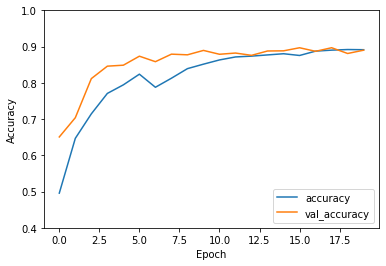

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')


In [10]:
!pip3 install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10031 sha256=20aaf8549867c0a8282dff89cfd8dad75b11d722b9e114c9834d72c64a7d57af
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [11]:

"""from keras.models import load_model


# returns a compiled model
# identical to the previous one

model = model.load_weights("/content/drive/My Drive/Masterlab/my_model.h5")"""


'from keras.models import load_model\n\n\n# returns a compiled model\n# identical to the previous one\n\nmodel = model.load_weights("/content/drive/My Drive/Masterlab/my_model.h5")'

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
f = lambda x : x + 1

# test accuracy
def check_testing():
  l_arr = []
  p_arr = []
    
  for d,l in test_sw:  
                                          # after unbatch   d(500,6)   l(500,12)
    if len(l_arr) == 0 and len(p_arr)==0:
      pred = model.predict(d)
      p = pred.reshape(-1,12)      # reduce dimension
      l = tf.reshape(l,(-1,12))    
      p_reformed = f(np.argmax(p, axis=1))       #(40000,)
      l_reformed = f(np.argmax(l, axis=1))       #(40000,)
      l_arr = l_reformed
      p_arr = p_reformed
    else:
      pred = model.predict(d)
      p = pred.reshape(-1,12)      # reduce dimension
      l = tf.reshape(l,(-1,12))
      p_reformed = f(np.argmax(p, axis=1))      
      l_reformed = f(np.argmax(l, axis=1))

      l_arr = np.hstack((l_arr, l_reformed))
      p_arr = np.hstack((p_arr, p_reformed))      #last (200000,)

  acc_score = accuracy_score(l_arr, p_arr)
  recall = recall_score(l_arr, p_arr, average="macro")
  precision = precision_score(l_arr, p_arr, average="macro")
  f1 = f1_score(l_arr, p_arr, average="macro")

  return [acc_score, recall, precision, f1]

print(check_testing())



def get_l_p():

  l_arr = []
  p_arr = []
    
  for d,l in test_sw:  
                                          # after unbatch   d(500,6)   l(500,12)
    if len(l_arr) == 0 and len(p_arr)==0:
      pred = model.predict(d)
      p = pred.reshape(-1,12)      # reduce dimension
      l = tf.reshape(l,(-1,12))    
      p_reformed = f(np.argmax(p, axis=1))       #(40000,)
      l_reformed = f(np.argmax(l, axis=1))       #(40000,)
      l_arr = l_reformed
      p_arr = p_reformed
    else:
      pred = model.predict(d)
      p = pred.reshape(-1,12)      # reduce dimension
      l = tf.reshape(l,(-1,12))
      p_reformed = f(np.argmax(p, axis=1))      
      l_reformed = f(np.argmax(l, axis=1))

      l_arr = np.hstack((l_arr, l_reformed))
      p_arr = np.hstack((p_arr, p_reformed))      #last (200000,)


  return l_arr, p_arr


[0.9211744186046512, 0.7517374168104567, 0.8002281368909946, 0.7660640849894826]


In [14]:
"""Get sequence after sliding window in array"""
def get_seq_arr(sw):      # call please use test_sw
  seq_x_arr = []
  seq_y_arr = []
  for x,y in sw:
    x_flatt2 = tf.reshape(x, [-1,6]) 
    y_flatt2 = tf.reshape(y, [-1,12]) 
    seq_x_arr.append(x_flatt2)
    seq_y_arr.append(y_flatt2)
  return seq_x_arr, seq_y_arr


seq_x_arr,seq_y_arr = get_seq_arr(test_sw)
print(len(seq_x_arr))   # len = 8 
print(len(seq_y_arr))   # len = 8 

# print(tf.shape(seq_x_arr[0]))    #  [40000     6]

43
43


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


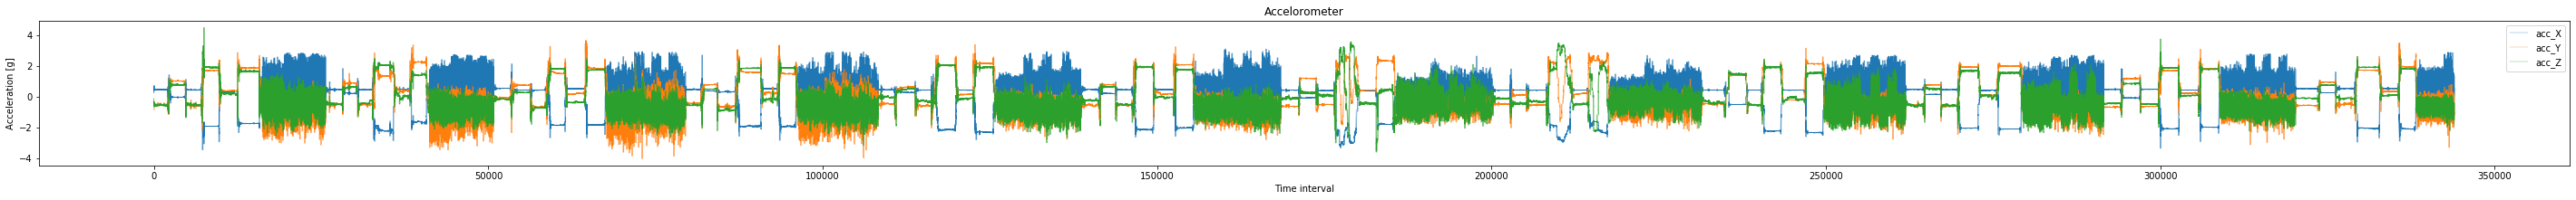

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


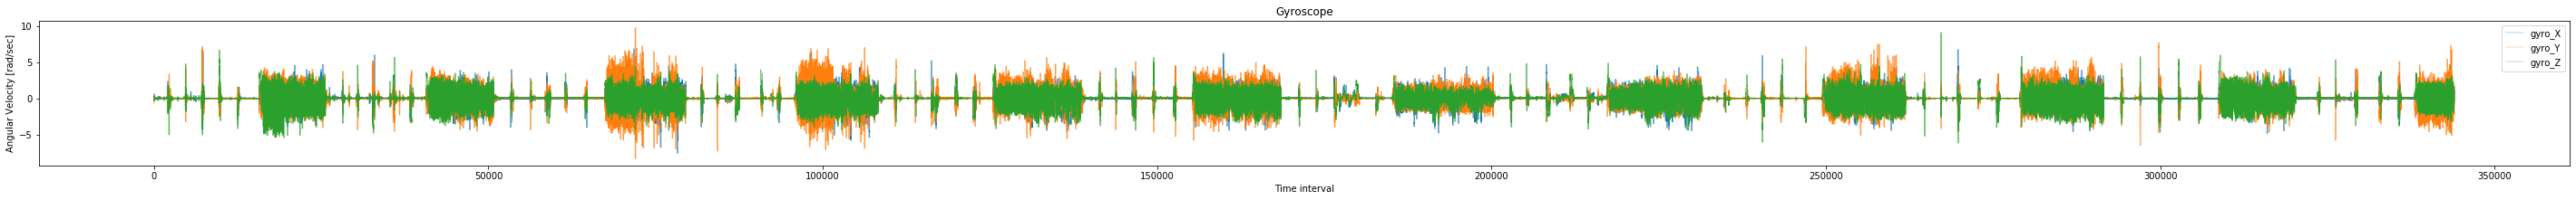

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


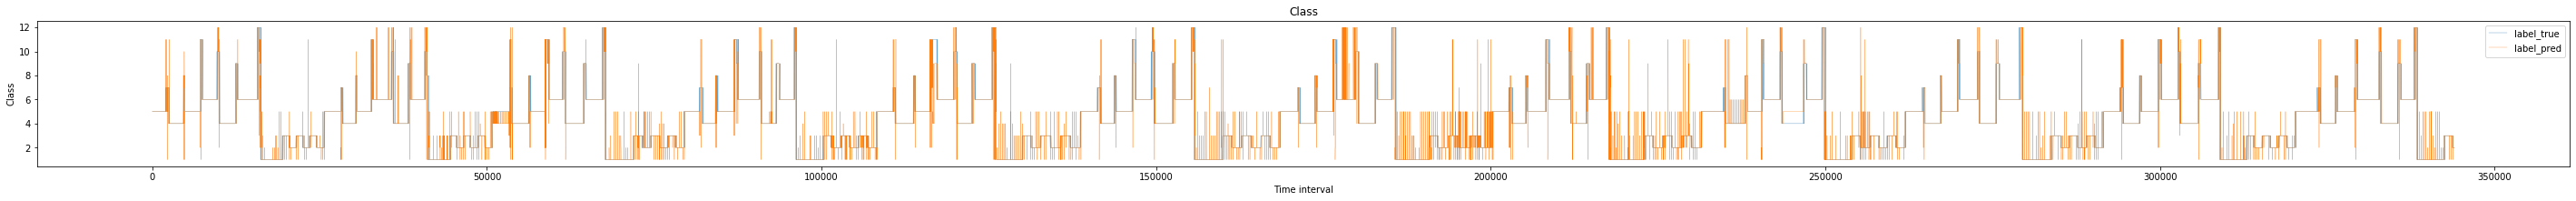

In [15]:
"""Get the whole sequence of test_sw"""

# Build whole sequences from test_sw

def build_seq(x_arr,y_arr):
  if len(x_arr) == len(y_arr):
    for i in range(0, len(x_arr)):
      if i == 0:
        seq_x_concat = x_arr[i]
        seq_y_concat = y_arr[i]
      else:
        seq_x_next = x_arr[i]
        seq_y_next = y_arr[i]
        seq_x_concat = tf.concat([seq_x_concat,seq_x_next],0)
        seq_y_concat = tf.concat([seq_y_concat,seq_y_next],0)
  else:
    print('Error. Check function get_seq_arr().')
  
  return seq_x_concat, seq_y_concat

seq_x,seq_y = build_seq(seq_x_arr,seq_y_arr)
# print(tf.shape(seq_x))     # [320000      6]
# print(tf.shape(seq_y))     # [320000      12]

# take out the data of x,y,z acceleration seperately
acc_X = seq_x[:,0]
acc_Y = seq_x[:,1]
acc_Z = seq_x[:,2]

# plot x,y,z acceleration in one figure
fig_acc = plt.figure(figsize=(50,10))
a = fig_acc.add_subplot(3,1,1)
a.set_title('Accelorometer')
plt.plot(acc_X,linewidth=0.3,label='acc_X')
plt.plot(acc_Y,linewidth=0.3,label='acc_Y')
plt.plot(acc_Z,linewidth=0.3,label='acc_Z')
plt.ylabel('Acceleration [g]')
plt.xlabel('Time interval') 
plt.legend()
plt.show()


# take out the data of x,y,z angular velocity seperately
gyro_X = seq_x[:,3]
gyro_Y = seq_x[:,4]
gyro_Z = seq_x[:,5]

#plot x,y,z angular velocity in one figure
fig_gyro = plt.figure(figsize=(50,10))
b = fig_gyro.add_subplot(3,1,2)
b.set_title('Gyroscope')
plt.plot(gyro_X,linewidth=0.3,label='gyro_X')
plt.plot(gyro_Y,linewidth=0.3,label='gyro_Y')
plt.plot(gyro_Z,linewidth=0.3,label='gyro_Z')
plt.ylabel('Angular Velocity [rad/sec]')
plt.xlabel('Time interval') 
plt.legend()
plt.show()

# get predicted labels of test dataset
f = lambda x: x+1
pred = model.predict(test_sw)
pred = tf.reshape(pred, [-1,12])         # (320000, 12)
pred_label = np.argmax(pred, axis = 1)   # change the prediction to class number
pred_label = f(np.array(pred_label).reshape(pred_label.size,)) # convert labels to one dimension

# get true label within one window
label_true = np.argmax(seq_y, axis=1)
label_true = f(np.array(label_true).reshape(label_true.size,))

# plot true label and predicted label in one figure
fig_label = plt.figure(figsize=(50,10))
c = fig_label.add_subplot(3,1,3)
c.set_title('Class')
plt.plot(label_true,linewidth=0.3,label='label_true')
plt.plot(pred_label,linewidth=0.3,label='label_pred')
plt.ylabel('Class')
plt.xlabel('Time interval')
plt.legend()
plt.show()


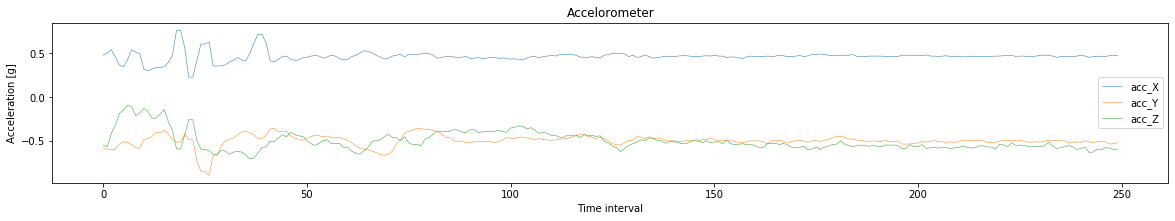

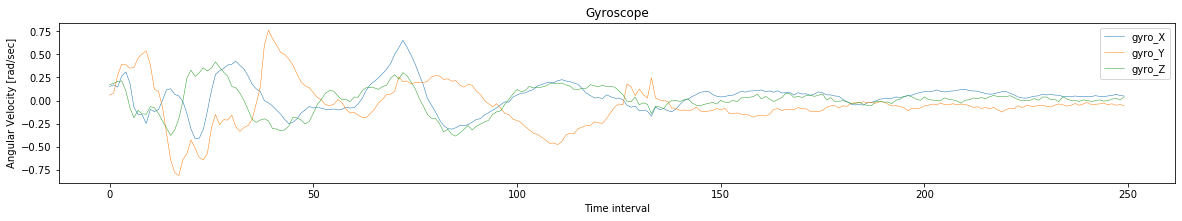

(8000,)


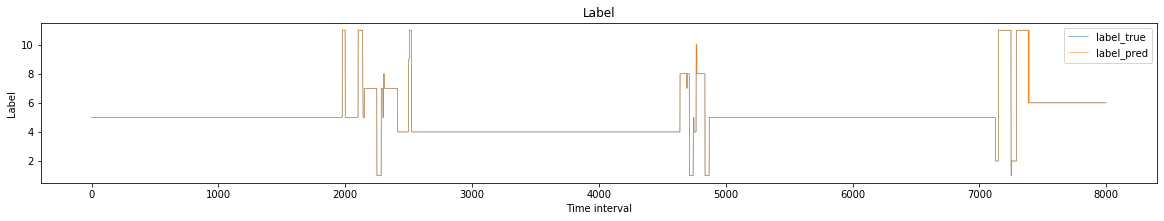

In [19]:


"""Get samples within one window length"""

for x,y in test_sw.unbatch().take(1):
  seq_x = x  
  seq_y = y

for x,y in test_sw.take(1):
  seq_x_batch = x  
  seq_y_batch = y

# take out the data of x,y,z acceleration within one window seperately
acc_X = seq_x[:,0]
acc_Y = seq_x[:,1]
acc_Z = seq_x[:,2]

# plot x,y,z acceleration within one window in one figure
fig_acc = plt.figure(figsize=(20,10))
a = fig_acc.add_subplot(3,1,1)
a.set_title('Accelorometer')
plt.plot(acc_X,linewidth=0.5,label='acc_X')
plt.plot(acc_Y,linewidth=0.5,label='acc_Y')
plt.plot(acc_Z,linewidth=0.5,label='acc_Z')
plt.ylabel('Acceleration [g]')
plt.xlabel('Time interval') 
plt.legend()
plt.show()


# take out the data of x,y,z angular velocity within one window seperately
gyro_X = seq_x[:,3]
gyro_Y = seq_x[:,4]
gyro_Z = seq_x[:,5]    #(175059, )

# plot x,y,z angular velocity within one window in one figure
fig_gyro = plt.figure(figsize=(20,10))
b = fig_gyro.add_subplot(3,1,2)
b.set_title('Gyroscope')
plt.plot(gyro_X,linewidth=0.5,label='gyro_X')
plt.plot(gyro_Y,linewidth=0.5,label='gyro_Y')
plt.plot(gyro_Z,linewidth=0.5,label='gyro_Z')
plt.ylabel('Angular Velocity [rad/sec]')
plt.xlabel('Time interval')
plt.legend() 
plt.show()

# get predicted labels of one window
f = lambda x: x+1
test_sample = test_sw.take(1)                                    # take one sample of unbatched test dataset
pred = model.predict(test_sample)
pred_label = np.argmax(pred, axis = 2)                           # predicted label of this sample
pred_label = f(np.array(pred_label).reshape(pred_label.size,))   # convert labels to one dimension
print(np.shape(pred_label))

# get true labels of one window
label_true = np.argmax(seq_y_batch, axis=2)
label_true = np.array(pred_label).reshape(pred_label.size,)

# # plot true label and predicted label of one window in one figure
fig_label = plt.figure(figsize=(20,10))
c = fig_label.add_subplot(3,1,2)
c.set_title('Label')
plt.plot(label_true,linewidth=0.5,label='label_true')
plt.plot(pred_label,linewidth=0.5,label='label_pred')
plt.ylabel('Label')
plt.xlabel('Time interval') 
plt.legend() 
plt.show()

(344000,)
(344000,)


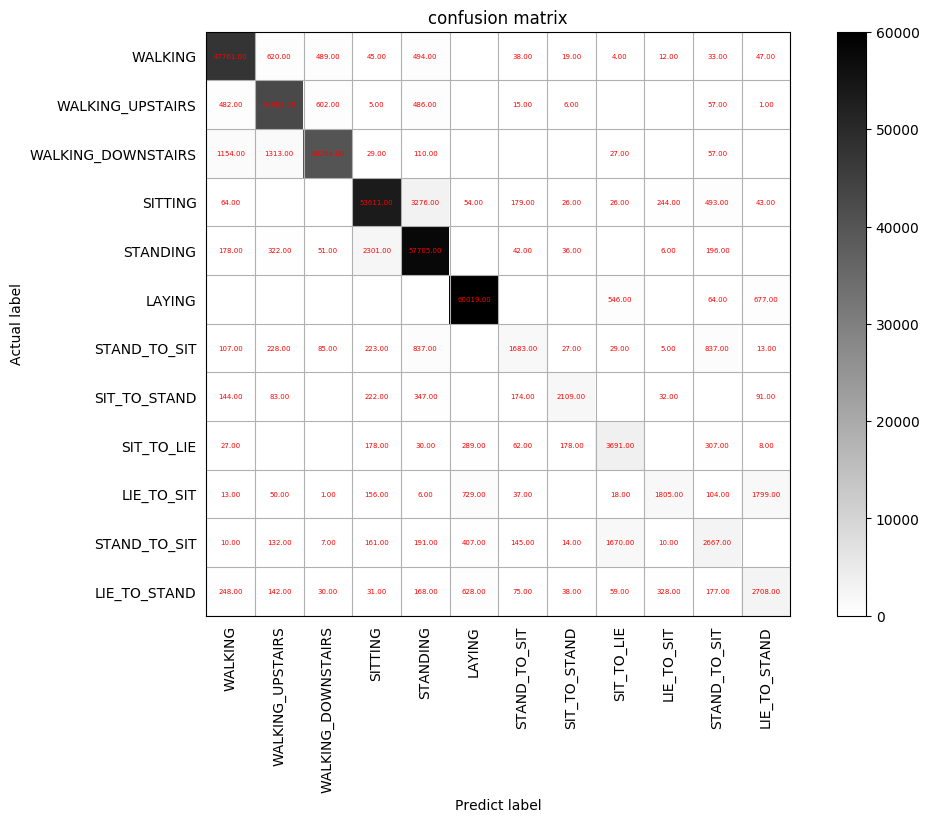

"if __name__ == '__main__':\n    print()"

In [17]:
# Metrics confusion matrix

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # the probabilities in confusion matrix
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=5, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()


classes = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT',
           'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_SIT', 'LIE_TO_STAND']

y_true, y_pred = get_l_p()
print(np.array(y_true).shape)
print(np.array(y_pred).shape)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, 'confusion_matrix.png', title='confusion matrix')
"""if __name__ == '__main__':
    print()"""